### Dataset Explanation:
#### The dataset consist of 90 images that are grouped into three categories: Source, Target, Groundtruth 30 images in each
#### Source:  RGB images that are being used for training as y_train, while scource converted to grayscale are being used as X_train
#### Target: grayscale images that are being used for prediction (we can say X_text)
#### Groundtruth: RGB images that are being used for evaluation (we can say y_test)

### Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import cv2
from tqdm import tqdm
import warnings
from scipy.ndimage import uniform_filter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.ndimage import uniform_filter
warnings.filterwarnings('ignore') # to avoid showing warnings

### Load Source Images and Extract Gray-scale Images

In [2]:
# create images and gray-scale images lists
images = []
gray_images = []

# define minimum and maximum image index
minImageIndex=1
maxImageIndex=30

for i in range(minImageIndex, maxImageIndex+1):
    if i<=9:
        # read bgr image and convert it to  rgb
        image=cv2.imread("images/p00"+str(i)+", a_source.png")[...,::-1]
    else:
        # read bgr image and convert it to  rgb
        image = cv2.imread("images/p0"+str(i)+", a_source.png")[...,::-1]

    # resize the image to 1/9 of its size
    image = cv2.resize(image, dsize=(image.shape[1]//9, image.shape[0]//9), interpolation=cv2.INTER_CUBIC)
    
    # extract the gray-scale image
    gray_image =(0.299 * image[:,:,0] +  0.587 * image[:,:,1] + 0.114 * image[:,:,2]).astype('uint8')
    
    # add images and gray-scale images to their coressponding lists
    images.append(image)
    gray_images.append(gray_image)

#show number of images we have
print("Number of Images Loaded:", len(images))
print("Number of Gray-Scaled Images:", len(gray_images))

Number of Images Loaded: 30
Number of Gray-Scaled Images: 30


### Preprocessing

#### Create Feature Extractor

In [3]:
# customized transformer that take gray-scale image, extract features and make it ready for training
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
 
    def fit(self, X):
        return self
 
    def transform(self, X):
        # make a copy of the image
        X_ = X.copy().astype(float)
        
        # extract the mean of 3x3 window for each pixel
        means= uniform_filter(X_, size=3, mode='constant')
        
        # extract the standard deviation of 3x3 window for each pixel
        means1= cv2.blur(X_, (3, 3))
        means2=cv2.blur(X_*X_, (3, 3))
        stds=(means2-(means1*means1))**0.5
        
        # extract edges from the gray-scale image
        edges = cv2.Canny((np.round(X*255)).astype('uint8'), 100, 200)
        
        # reshape each of the features to (nx1) shape
        X_=X_.flatten().reshape(-1,1)
        means=means.flatten().reshape(-1, 1)
        stds=stds.flatten().reshape(-1, 1)
        edges = edges.flatten().reshape(-1, 1)
        
        # stack the features horizontally 
        X_ = np.hstack((X_, means, stds, edges))
 
        return X_ # (nx4) matrix
    

#### Create RGB Transformer

In [4]:
# customized transformer that is used for shaping and reshaping RGB images
class RgbTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, y):
        return self

    def transform(self, y):
        # make a copy of the image
        y_ = y.copy()
        
        # split the image into three channels red, green, and blue
        y_r, y_g, y_b = y_[:,:,0], y_[:,:,1], y_[:,:,2]
        
        # reshape each of the channels to (nx1) shape
        y_r=y_r.flatten().reshape(-1,1)
        y_g=y_g.flatten().reshape(-1,1)
        y_b=y_b.flatten().reshape(-1,1)
        
        # stack the channels horizontally
        y_= np.hstack((y_r, y_g, y_b))

        return y_ # (nx3) matrix
    
    def inverse_transform(self, y_pred, shape):
        # make a copy of the image
        y_pred_ = y_pred.copy()
        
        # reshape image
        y_pred_ = y_pred_.reshape(shape)

        return y_pred_ 
    

#### Extract Features and Shape Training Set

In [5]:
# Extract features matrices
X_trains = list(map(FeatureExtractor().fit_transform, gray_images))

# extract targets(labels) matrices
y_trains = list(map(RgbTransformer().fit_transform, images))

print("number of images in training set:", len(X_trains))

number of images in training set: 30


### Grid Search Cross Validation On Training Set

In [6]:
# create regressors list
Regressors = []

# define parameters to be tested by grid search
parameters = {'estimator__n_neighbors':range(1, 50, 2)}

for i in tqdm(range(len(images))):
    # define MultiOutput Regressor that use K-neighbors regressor as an estimator
    regressor = MultiOutputRegressor(KNeighborsRegressor(), n_jobs=-1)
    
    # perform grid search on each image in training set
    grid = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_trains[i], y_trains[i])
    
    # add the best best estimator found by grid search to regressors list
    Regressors.append(grid.best_estimator_)


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]


### Load Target and Ground Truth Images 

In [7]:
# create grays, originals, and shapes lists
grays = []
originals = []
shapes = [] # to be used later in forming predicted images

for i in range(minImageIndex, maxImageIndex+1):
    if i<=9:
        # read gray-scale image
        gray=cv2.imread("images/p00"+str(i)+", b_target.png", cv2.IMREAD_GRAYSCALE)
        
        # read bgr image and convert it to rgb
        original=cv2.imread("images/p00"+str(i)+", c_groundtruth.png")[...,::-1]
        
    else:
        # read gray-scale image
        gray=cv2.imread("images/p0"+str(i)+", b_target.png", cv2.IMREAD_GRAYSCALE)
        
        # read bgr image and convert it to rgb
        original=cv2.imread("images/p0"+str(i)+", c_groundtruth.png")[...,::-1]
    
    
    # add original image, gray image, and shape to their coressponding lists
    originals.append(original)
    grays.append(gray)
    shapes.append(original.shape)

#show number of images we have  
print("Number of Target Images Loaded:", len(grays))
print("Number of Ground Truth Images Loaded:", len(originals))

Number of Target Images Loaded: 30
Number of Ground Truth Images Loaded: 30


### Extract Features and Shape Testing Set

In [8]:
# Extract features matrices
X_tests = [FeatureExtractor().fit_transform(gray) for gray in grays]

# extract targets(labels) matrices
y_tests = [RgbTransformer().fit_transform(original) for original in originals]

print("number of images in testing set:", len(X_tests))

number of images in testing set: 30


### Make Predictions

In [9]:
# create y_preds list
y_preds = []
for i in tqdm(range(len(X_tests))):
    # predict for each image in testing set and add it to y_preds list
    y_preds.append((np.round(Regressors[i].predict(X_tests[i]))).astype('uint8'))
    

100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


### Shape the predicted images

In [10]:
predicted_images = [RgbTransformer().inverse_transform(y_preds[i], shapes[i]) for i in range(len(y_preds))]


### Plot images

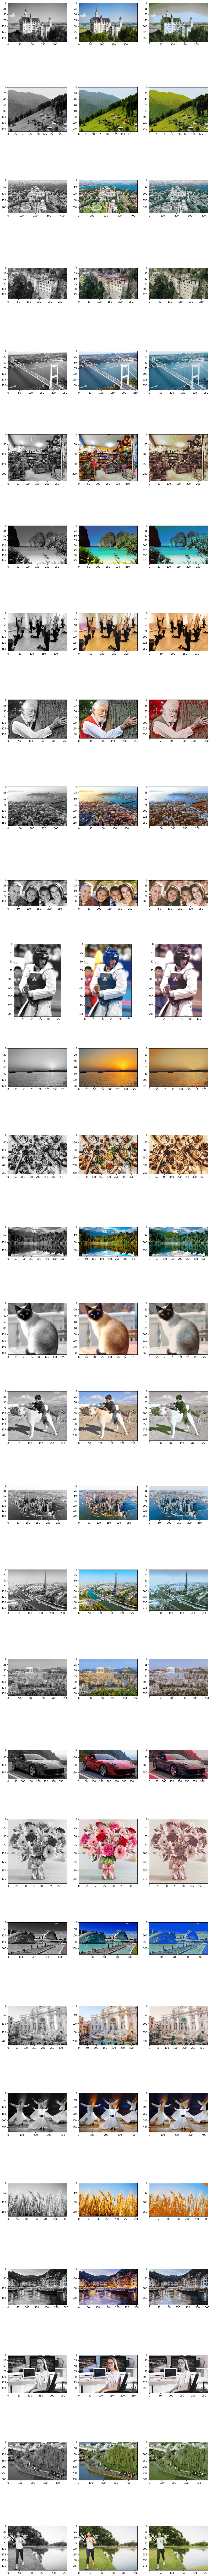

In [11]:
# create plots grid
fig, axs = plt.subplots(len(grays), 3, figsize=(15,200))

# plot images
for i in range(len(grays)):
    axs[i,0].imshow(grays[i], cmap='gray') # plot target image
    axs[i,1].imshow(originals[i]) # plot groundtruth image
    axs[i,2].imshow(predicted_images[i]) # plot predicted image


### Evaluating Results

In [12]:
# create and compute Mean Absolute Errors list
mae_scores = [mean_absolute_error(y_tests[i],y_preds[i]) for i in range(len(y_preds))]

# show Mean Absolute Error for each image
for i in range(len(mae_scores)):
    print('score for image',i+1,'is', mae_scores[i])
print()

# show the average Mean Absolute Error for all images
print('average MAE for all images is',np.mean(mae_scores))


score for image 1 is 106.87797205588822
score for image 2 is 95.13853333333334
score for image 3 is 121.25374688817762
score for image 4 is 127.56698453772923
score for image 5 is 117.2466403280357
score for image 6 is 111.1368954248366
score for image 7 is 104.77149659863944
score for image 8 is 136.60262314439947
score for image 9 is 150.2640465391139
score for image 10 is 123.15975960936521
score for image 11 is 101.87834385964912
score for image 12 is 110.59508945656334
score for image 13 is 117.34180766196197
score for image 14 is 117.9744838921762
score for image 15 is 117.101108033241
score for image 16 is 110.55656031211588
score for image 17 is 116.7518766349993
score for image 18 is 123.98531629494404
score for image 19 is 122.04887706855793
score for image 20 is 127.62901204427084
score for image 21 is 125.12095410302082
score for image 22 is 117.64478902243836
score for image 23 is 94.05765095119934
score for image 24 is 115.20737121567053
score for image 25 is 102.10586840

### Show Regressors used for each Image

In [13]:
Regressors

[MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=9), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=7), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=17), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=7), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=7), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=7), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=9), n_jobs=-1),
 MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=1